# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting, which has been implemented in the `libs/unet.py` module. First let us get required packages.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import os
import gc
import copy

import numpy as np
from PIL import Image
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'partial-convolution':
    os.chdir('..')

from libs.util import MaskGenerator
from libs.pconv_model import PConvUnet

# Settings
BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

%matplotlib inline
print("Version: ", tf.version.VERSION)
# physical_devices = tf.config.list_physical_devices()
# print(physical_devices)

Version:  1.15.0


Using TensorFlow backend.


Let us quickly check the architecture of the network.

In [4]:
os.chdir('partial-convolution/')

In [2]:
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices {}'.format(strategy.num_replicas_in_sync))

# with strategy.scope() :
model = PConvUnet(vgg_weights='data/logs/pytorch_to_keras_vgg16.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(3, 

# Testing out on single image
For the purpose of checking whether the model works, we'll try training the network on a single image; i.e. training and test dataset will essentially be the same, but this is simply to validate that the network learns something.

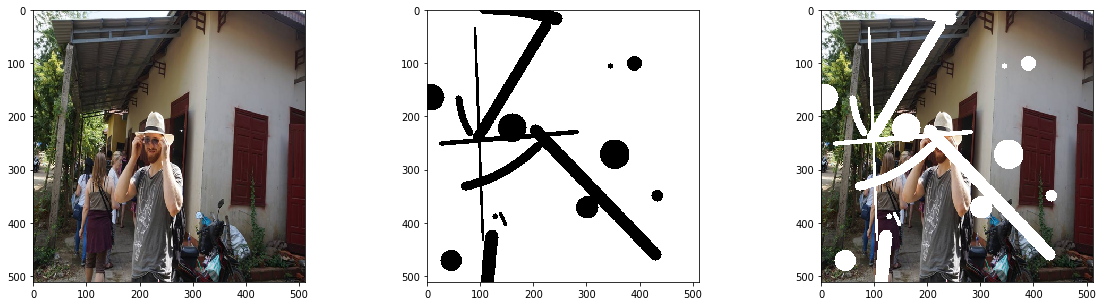

In [3]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Load image
img = np.array(Image.open('./data/sample_image.jpg').resize((512, 512))) / 255

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us, except each each yielded image will be slightly altered/augmented by using `ImageDataGenerator` from `keras.processing`. 

In [8]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

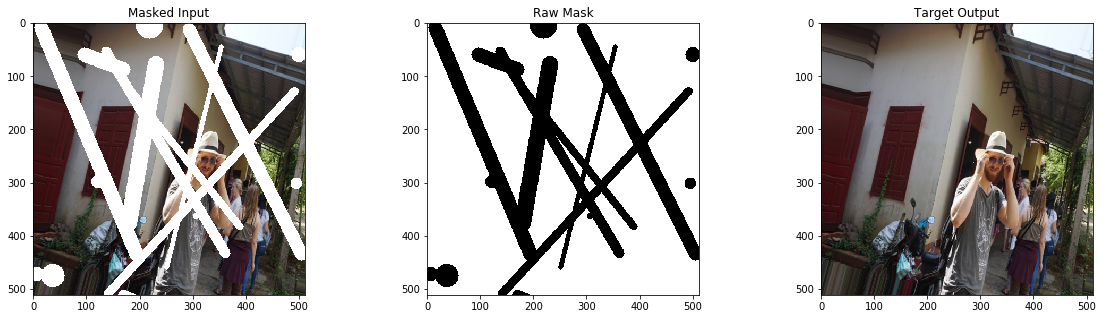

In [9]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

## Training the inpainting UNet on single image
Now that we have a generator, we can initiate our training. For conveience the `fit()` method of the `PConvUnet` takes a callback, which we can use to evaluate and display the progress in terms of reconstructing the target based on the masked input.

In [10]:
# Instantiate model
model = PConvUnet(vgg_weights='./data/logs/pytorch_to_keras_vgg16.h5')

tracking <tf.Variable 'p_conv2d_33/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_34/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_35/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_36/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_37/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_38/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_39/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_40/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_41/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_42/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

Epoch 1/1
200/200 [==============================] - 2719s 14s/step - loss: 8.0305 - PSNR: 11.3187


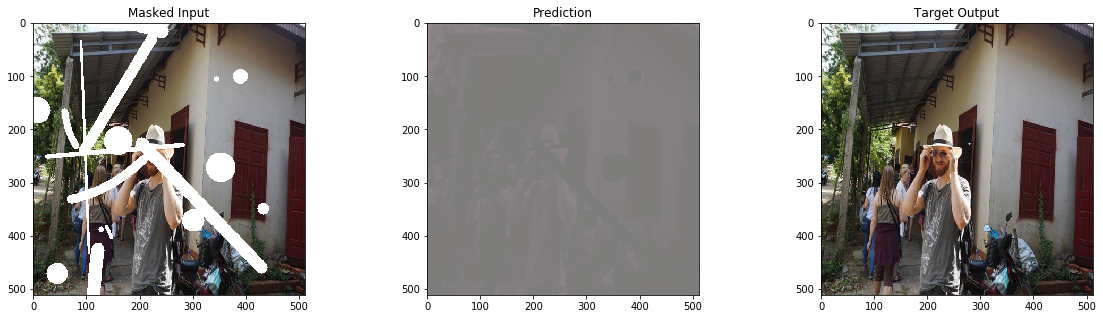

In [11]:
model.fit_generator(
    generator, 
    steps_per_epoch=200,
    epochs=1,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)

# Toplist
* Before VGG scaling - loss: 514023.1397 - PSNR: 24.9732 - 555ms/step
* After VGG scaling - loss: 21988.2789 - PSNR: 17.4213 - 555ms/step
* VGG & UNet both on GPU - 1003s 753ms/step
* VGG on 1 GPU, UNet on both - 992s 744ms/step
* VGG on CPU - SLOW AS FUCK
* VGG from Pytorch, All scaling as Pytorch pretrained: 